## 对抗训练

## 白盒攻击得到增强的训练数据


In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
train_data = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform_test)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)

# 定义攻击函数
def fgsm_attack(image, epsilon, max_iter, model, target):
    if epsilon == 0:
            return False, perturbed_image
    perturbed_image = image
    attack_target = (target + 1) % 10
    # 迭代更新扰动值
    for i in range(max_iter):
        # 计算梯度并更新扰动值
        # perturbed_image.requires_grad = True
        perturbed_image.requires_grad_(True)
        output = model(perturbed_image)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, attack_target)
        model.zero_grad()
        loss.backward()
        # print(perturbed_image.grad.size())
        if epsilon == 0:
            return False, perturbed_image
        if perturbed_image.grad is None:
            return False, perturbed_image
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image - epsilon * data_grad.sign()
        # 限制像素值范围在[0,1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # 如果扰动图像已经被误分类，停止攻击
        if model(perturbed_image).max(1, keepdim=True)[1] == attack_target:
            return True, perturbed_image
    return False, perturbed_image

# 定义测试函数
def test(model, device, test_loader, epsilon):
    model.eval()
    success_num = 0
    correct = 0
    adv_examples = []
    cnt = 0
    for data, target in test_loader:
        # 找到被分类正确的图像
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        correct += 1
        success, perturbed_data = fgsm_attack(image=data, epsilon=epsilon, max_iter=50, model=model, target=target)
        if success:
            success_num += 1
            adv_examples.append((cnt, data, perturbed_data, target))
        # 打印进度信息
        if correct % 600 == 0:
            print(f"Epsilon: {epsilon}\tAttack progress: {correct} / {len(test_loader)}\tsuccess:{success_num}")
        cnt += 1
    # 计算攻击成功率
    attack_acc = success_num / float(correct)
    print(f"Epsilon: {epsilon}\tCorrect Sum: {correct}\tAttack success rate: {attack_acc:.4f}")
    return attack_acc, adv_examples

# 设置攻击参数
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
epsilons = [0.02]
attack_accs = []
examples = []

# 加载模型
# model = torchvision.models.resnet34(weights=None, num_classes=10)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
# model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
# model.load_state_dict(torch.load('../checkpoints/checkpoint-60-93.71.pt', map_location=device))
model = torch.load('../checkpoints/ResNetO-epo19-acc93.42.ckpt')
model.to(device)
# 对模型进行测试和攻击

for eps in epsilons:
    acc, ex = test(model, device, train_loader, eps)
    attack_accs.append(acc)
    examples.append(ex)
    if not os.path.exists('../attack_data'):
        os.makedirs('../attack_data')    
    torch.save(ex, f'../attack_data/White-TrainWithIndx-eps-{eps:.3f}-ASR-{acc:.3f}.pt')


# torch.save(examples, '../attack_data/attack_examples.pt')

# plt.figure(figsize=(5,5))
# plt.plot(epsilons, attack_accs, "*")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
# plt.title("Attack Success Rate vs Epsilon 0.02 (Train data)")
# plt.xlabel("Epsilon")
# plt.ylabel("Attack Success Rate")
# plt.show()

cuda


C:\Users\01\AppData\Local\Temp\ipykernel_12772\1039757537.py:36: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:491.)
  if perturbed_image.grad is None:


Epsilon: 0.02	Attack progress: 600 / 60000	success:78
Epsilon: 0.02	Attack progress: 1200 / 60000	success:164
Epsilon: 0.02	Attack progress: 1800 / 60000	success:232
Epsilon: 0.02	Attack progress: 2400 / 60000	success:299
Epsilon: 0.02	Attack progress: 3000 / 60000	success:371
Epsilon: 0.02	Attack progress: 3600 / 60000	success:442
Epsilon: 0.02	Attack progress: 4200 / 60000	success:520
Epsilon: 0.02	Attack progress: 4800 / 60000	success:590
Epsilon: 0.02	Attack progress: 5400 / 60000	success:647
Epsilon: 0.02	Attack progress: 6000 / 60000	success:718
Epsilon: 0.02	Attack progress: 6600 / 60000	success:780
Epsilon: 0.02	Attack progress: 7200 / 60000	success:862
Epsilon: 0.02	Attack progress: 7800 / 60000	success:924
Epsilon: 0.02	Attack progress: 8400 / 60000	success:997
Epsilon: 0.02	Attack progress: 9000 / 60000	success:1060
Epsilon: 0.02	Attack progress: 9600 / 60000	success:1133
Epsilon: 0.02	Attack progress: 10200 / 60000	success:1196
Epsilon: 0.02	Attack progress: 10800 / 60000	s

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torchvision
import numpy as np
import random

# 加载测试集类别
test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())
class_names = list(test_data.classes)
print(class_names)
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
adv_examples = torch.load('../attack_data/White-Train-eps-0.020-ASR-0.143.pt', map_location=device)
random.seed(191)
random.shuffle(adv_examples)
print(len(adv_examples))

# torch.manual_seed(2023)
fig = plt.figure(figsize=(9, 9))
rows, cols = 6, 6
cnt = 1
for i, (data, perturbed_data, target) in enumerate(adv_examples):
    if cnt > rows * cols:
        break
    random_idx = target.item()
    fig.add_subplot(rows, cols, cnt)
    plt.imshow(data.cpu().detach().numpy().squeeze(), cmap="gray")
    plt.title(class_names[random_idx])
    plt.axis(False)
    # plt.imsave(f'../images/White-N{cnt // 2}-Original-{random_idx}-{class_names[random_idx]}.png', data.cpu().detach().numpy().squeeze())
    cnt += 1

    fig.add_subplot(rows, cols, cnt)
    plt.imshow(perturbed_data.cpu().detach().numpy().squeeze(), cmap="gray")
    attack_target = (random_idx + 1) % 10
    plt.title(class_names[attack_target])
    plt.axis(False)
    # plt.imsave(f'../images/White-N{(cnt-1) // 2}-Perturbed-{attack_target}-{class_names[attack_target]}.png', perturbed_data.cpu().detach().numpy().squeeze())
    cnt += 1
fig.subplots_adjust(hspace=0.3, wspace=0.1)

60000
cuda
Epoch 1: Train Loss: 0.6886, Train Accuracy: 74.31%, Test Loss: 0.4241, Test Accuracy: 84.17%
Epoch 2: Train Loss: 0.4610, Train Accuracy: 83.04%, Test Loss: 0.3774, Test Accuracy: 85.99%
Epoch 3: Train Loss: 0.4051, Train Accuracy: 85.16%, Test Loss: 0.3312, Test Accuracy: 87.78%
Epoch 4: Train Loss: 0.3730, Train Accuracy: 86.26%, Test Loss: 0.3101, Test Accuracy: 88.69%
Epoch 5: Train Loss: 0.3506, Train Accuracy: 87.15%, Test Loss: 0.2951, Test Accuracy: 89.46%
Epoch 6: Train Loss: 0.3346, Train Accuracy: 87.87%, Test Loss: 0.2731, Test Accuracy: 90.41%
Epoch 7: Train Loss: 0.3216, Train Accuracy: 88.15%, Test Loss: 0.2711, Test Accuracy: 89.77%
Epoch 8: Train Loss: 0.3174, Train Accuracy: 88.34%, Test Loss: 0.2744, Test Accuracy: 90.01%
Epoch 9: Train Loss: 0.3060, Train Accuracy: 88.67%, Test Loss: 0.2532, Test Accuracy: 90.71%
Epoch 10: Train Loss: 0.2944, Train Accuracy: 89.23%, Test Loss: 0.2766, Test Accuracy: 90.14%
Epoch 11: Train Loss: 0.2414, Train Accuracy: 91

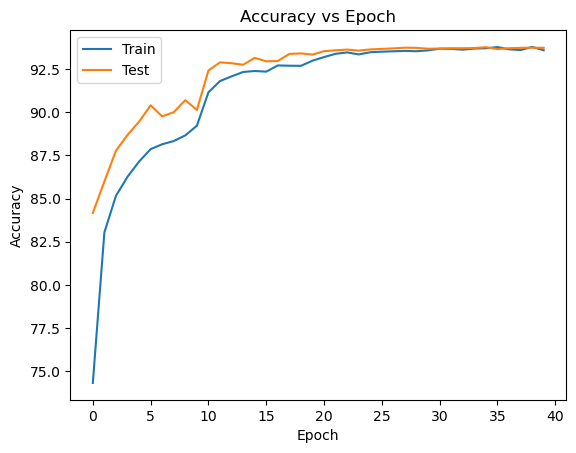

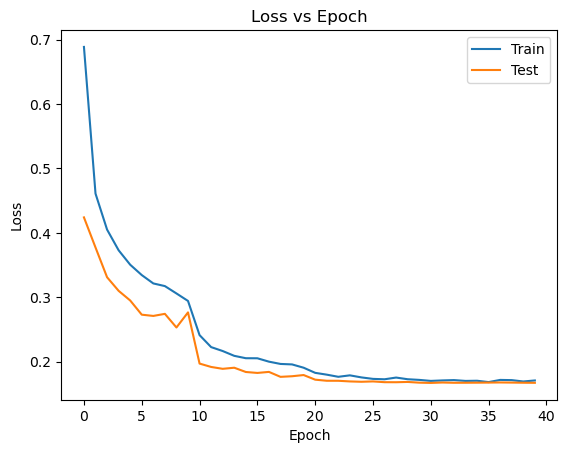

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet34
import matplotlib.pyplot as plt
import os

# 定义训练函数
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

# 定义测试函数
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy



transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.2860,), std=(0.3530,)),
    transforms.RandomErasing()
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.2860,), std=(0.3530,))
])
train_dataset = datasets.FashionMNIST(root='../data/', download=False, train=True, transform=transform_train)
test_dataset = datasets.FashionMNIST(root='../data/', download=False, train=False, transform=transform_test)
print(len(train_dataset))
# print(len(test_dataset))
# 定义模型
model = resnet34(weights=None)  # 加载预训练模型
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 更改第一层卷积层
model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_batch_size = 128
test_batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=8)
model = model.to(device)
model = torch.nn.DataParallel(model).cuda() # 多GPU并行计算
train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

for epoch in range(40):
    train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer)
    scheduler.step() # 更新学习率
    test_loss, test_accuracy = test(model, device, test_loader, criterion)

    print('Epoch {}: Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
        epoch + 1, train_loss, train_accuracy, test_loss, test_accuracy))
    
    if not os.path.exists('../checkpoints'):
        os.makedirs('../checkpoints/')
    torch.save(model, '../checkpoints/ResNetO-epo{}-acc{}.ckpt'.format(epoch+1,test_accuracy))

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

# 绘制精度曲线
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

# 绘制损失曲线
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()



['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
60140
torch.Size([1, 28, 28])
cuda
Start Training
Epoch 1: Train Loss: 0.5883, Train Accuracy: 78.13%, Test Loss: 0.4179, Test Accuracy: 84.29%
Epoch 2: Train Loss: 0.3743, Train Accuracy: 86.16%, Test Loss: 0.3283, Test Accuracy: 87.98%
Epoch 3: Train Loss: 0.3213, Train Accuracy: 87.94%, Test Loss: 0.2954, Test Accuracy: 89.43%
Epoch 4: Train Loss: 0.2843, Train Accuracy: 89.59%, Test Loss: 0.2904, Test Accuracy: 89.39%
Epoch 5: Train Loss: 0.2556, Train Accuracy: 90.64%, Test Loss: 0.3170, Test Accuracy: 88.95%
Epoch 6: Train Loss: 0.2329, Train Accuracy: 91.44%, Test Loss: 0.3379, Test Accuracy: 88.01%
Epoch 7: Train Loss: 0.2135, Train Accuracy: 92.03%, Test Loss: 0.3222, Test Accuracy: 88.89%
Epoch 8: Train Loss: 0.1949, Train Accuracy: 92.77%, Test Loss: 0.2830, Test Accuracy: 90.26%
Epoch 9: Train Loss: 0.1797, Train Accuracy: 93.38%, Test Loss: 0.3475, Test Accuracy: 87.6

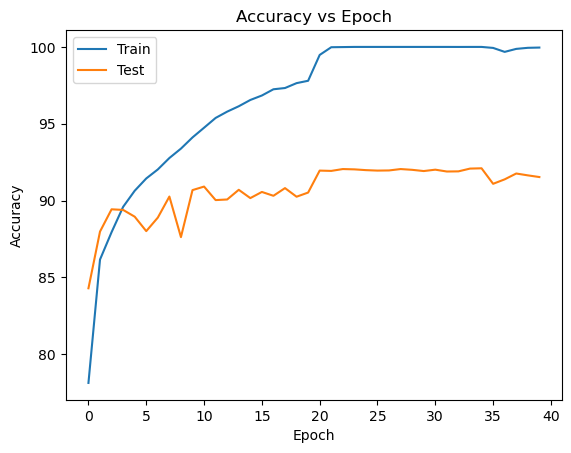

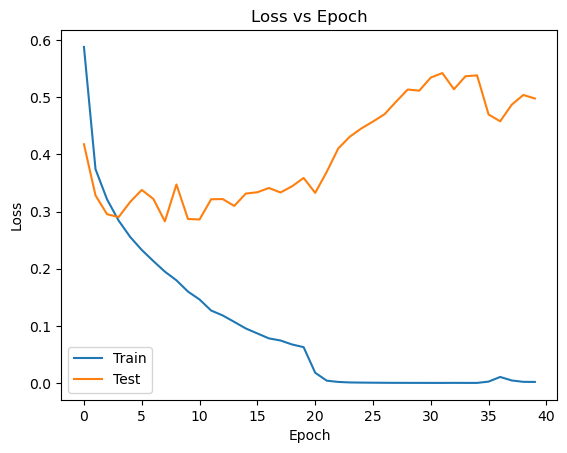

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet34
import matplotlib.pyplot as plt
from torchvision import datasets
import os
import numpy as np
import random

# 定义训练函数
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

# 定义测试函数
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy


transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.2860,), std=(0.3530,)),
    transforms.RandomErasing()
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.2860,), std=(0.3530,))
])
train_dataset0 = datasets.FashionMNIST(root='../data/', download=False, train=True, transform=transform_train)
train_dataset1 = datasets.FashionMNIST(root='../data/', download=False, train=True, transform=transform_test)
test_dataset = datasets.FashionMNIST(root='../data/', download=False, train=False, transform=transform_test)
class_names = list(test_dataset.classes)
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
adv_examples = torch.load('../adv_img/White-Train-eps-0.020-ASR-0.143.pt', map_location=device)

train_img=[]
train_label=[]
cnt = 0
for i in range(len(train_dataset0)):
    train_img.append(train_dataset0[i][0].cpu().detach().numpy().squeeze())
    train_label.append(train_dataset0[i][1])
    # if i % 100 == 0:
        # train_img.append(train_dataset1[i][0].cpu().detach().numpy().squeeze())
        # train_label.append(train_dataset1[i][1])
        # cnt += 1
    cnt += 1
random.seed(2023)
random.shuffle(adv_examples)
for (data, perturbed_data, targets) in adv_examples:
    train_img.append(perturbed_data.cpu().detach().numpy().squeeze())
    train_label.append(targets.cpu().detach().numpy().squeeze())
    cnt += 1
    if cnt > 60139:
        break
train_img=np.array(train_img)
train_label=np.array(train_label)
# print(train_img.shape)
# print(train_label.shape)
# print(train_label[0])
# print(type(train_label[0]))
train_img = torch.from_numpy(train_img).reshape(cnt, 1, 28, 28).float()
train_label = torch.from_numpy(train_label).long()
# print(train_img.shape)
# print(train_label.shape)
train_dataset = torch.utils.data.TensorDataset(train_img, train_label)
print(len(train_dataset))
print(train_dataset[0][0].shape)
class_names[0]='T-shirt top'
# 定义模型
model = resnet34(weights=None)  # 加载预训练模型
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 更改第一层卷积层
model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_batch_size = 256
test_batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=8)
model = model.to(device)
model = torch.nn.DataParallel(model).cuda() # 多GPU并行计算
train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
print('Start Training')
for epoch in range(40):
    train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer)
    scheduler.step() # 更新学习率
    test_loss, test_accuracy = test(model, device, test_loader, criterion)

    print('Epoch {}: Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
        epoch + 1, train_loss, train_accuracy, test_loss, test_accuracy))
    
    if not os.path.exists('../checkpoints'):
        os.makedirs('../checkpoints/')
    torch.save(model, '../checkpoints/NewR-epo{}-acc{}.ckpt'.format(epoch+1,test_accuracy))

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

# 绘制精度曲线
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

# 绘制损失曲线
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()



              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.87      0.90      0.88      1000
           3       0.94      0.90      0.92      1000
           4       0.87      0.89      0.88      1000
           5       0.99      0.98      0.98      1000
           6       0.78      0.73      0.76      1000
           7       0.95      0.97      0.96      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Cohen's kappa: 0.912


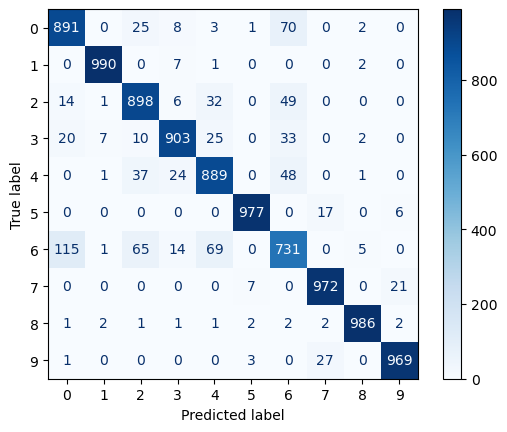

In [4]:
import torch
import torch.nn as nn
import sklearn.metrics as metrics
from torch.utils.data import DataLoader
from torchvision.models import resnet34
from torchvision import datasets, transforms
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
# model = resnet34(weights=None)  # 加载预训练模型
# num_classes = 10
# in_channels = 1  # 输入通道数为1
# model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 更改第一层卷积层
# in_features = model.fc.in_features
# model.fc = nn.Linear(in_features, num_classes)  # 更改最后一层全连接层
# dict = torch.load('../model/checkpoint-60-93.71.pt', map_location=device)
# model.load_state_dict(dict)
# model.to(device)
# model = torch.load('../checkpoints/New-epo14-acc94.02.ckpt')
model = torch.load('../checkpoints/NewR-epo16-acc92.06.ckpt')
model.eval()
# 评估模型
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.2860,), std=(0.3530,))
])
test_dataset = datasets.FashionMNIST(root='../data/', download=False, train=False, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=8)
y_true = []
y_pred = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = output.max(1)
        y_true.extend(target.cpu().numpy().tolist())
        y_pred.extend(predicted.cpu().numpy().tolist())

# 计算混淆矩阵
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
# 给混淆矩阵行列加上标签
confusion_matrix = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=range(10))
# 绘制混淆矩阵
%matplotlib inline
confusion_matrix.plot(cmap='Blues', values_format='d')
# print(confusion_matrix)
# 计算分类报告
classification_report = metrics.classification_report(y_true, y_pred)
print(classification_report)
# 计算 Cohen's kappa 系数
cohen_kappa_score = metrics.cohen_kappa_score(y_true, y_pred)
print(f"Cohen\'s kappa: {cohen_kappa_score:.3f}")

cuda


C:\Users\01\AppData\Local\Temp\ipykernel_18844\3472411473.py:36: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:491.)
  if perturbed_image.grad is None:


Epsilon: 0.02	Attack progress: 1000 / 10000	success:8
Epsilon: 0.02	Attack progress: 2000 / 10000	success:13
Epsilon: 0.02	Attack progress: 3000 / 10000	success:17
Epsilon: 0.02	Attack progress: 4000 / 10000	success:19
Epsilon: 0.02	Attack progress: 5000 / 10000	success:24
Epsilon: 0.02	Attack progress: 6000 / 10000	success:28
Epsilon: 0.02	Attack progress: 7000 / 10000	success:33
Epsilon: 0.02	Attack progress: 8000 / 10000	success:37
Epsilon: 0.02	Attack progress: 9000 / 10000	success:46
Epsilon: 0.02	Attack success rate: 0.0051


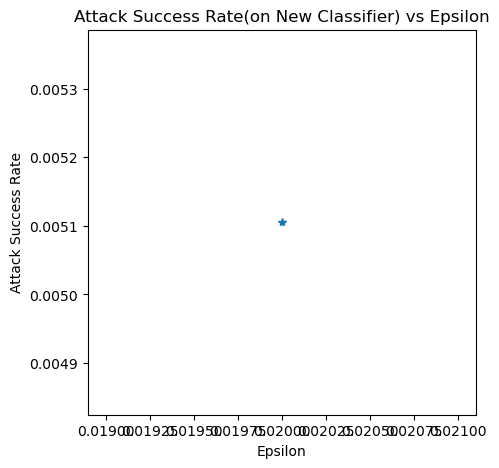

In [5]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

# 定义攻击函数
def fgsm_attack(image, epsilon, max_iter, model, target):
    if epsilon == 0:
            return False, perturbed_image
    perturbed_image = image
    attack_target = (target + 1) % 10
    # 迭代更新扰动值
    for i in range(max_iter):
        # 计算梯度并更新扰动值
        # perturbed_image.requires_grad = True
        perturbed_image.requires_grad_(True)
        output = model(perturbed_image)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, attack_target)
        model.zero_grad()
        loss.backward()
        # print(perturbed_image.grad.size())
        if epsilon == 0:
            return False, perturbed_image
        if perturbed_image.grad is None:
            return False, perturbed_image
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image - epsilon * data_grad.sign()
        # 限制像素值范围在[0,1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # 如果扰动图像已经被误分类，停止攻击
        if model(perturbed_image).max(1, keepdim=True)[1] == attack_target:
            return True, perturbed_image
    return False, perturbed_image

# 定义测试函数
def test(model, device, test_loader, epsilon):
    model.eval()
    success_num = 0
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        # 找到被分类正确的图像
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        correct += 1

        success, perturbed_data = fgsm_attack(image=data, epsilon=epsilon, max_iter=100, model=model, target=target)
        if success:
            success_num += 1
            adv_examples.append((data, perturbed_data, target))
        # 打印进度信息
        if correct % 1000 == 0:
            print(f"Epsilon: {epsilon}\tAttack progress: {correct} / {len(test_loader)}\tsuccess:{success_num}")
        # if correct == 2000:
            # break
    # 计算攻击成功率
    attack_acc = success_num / float(correct)
    print(f"Epsilon: {epsilon}\tAttack success rate: {attack_acc:.4f}")
    return attack_acc, adv_examples

# 设置攻击参数
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
epsilons = [.02]
attack_accs = []
examples = []

# 加载模型
# model = torchvision.models.resnet34(weights=None, num_classes=10)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
# model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
# model.load_state_dict(torch.load('../checkpoints/checkpoint-60-93.71.pt', map_location=device))
model.to(device)
# 对模型进行测试和攻击

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    attack_accs.append(acc)
    examples.append(ex)
    if not os.path.exists('../attack_data'):
        os.makedirs('../attack_data')    
    torch.save(ex, f'../attack_data/new-white-eps-{eps:.2f}-ASR-{acc:.2f}.pt')


torch.save(examples, '../attack_data/attack_examples.pt')


plt.figure(figsize=(5,5))
plt.plot(epsilons, attack_accs, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Attack Success Rate(on New Classifier) vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Attack Success Rate")
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import random
import pickle
import datetime

def attack_mcmc(data, target, model, device, max_step = 200, std = 0.02, thres_d = 0.05):
    attack_target = (target + 1) % 10
    for i in range(max_step):
        # transition
        # data_new = torch.normal(data, std=std).to(device)
        u = torch.rand(1, device=device)
        data_new = torch.normal(data, std=std).to(device)
        with torch.no_grad():
            pred = F.softmax(model(data_new), dim=-1)
        y_prime = pred[0][attack_target]
        if y_prime >= u:
            continue
        # print(f"l1-loss: \r{F.l1_loss(data_new, data, reduction='mean')}")
        if F.l1_loss(data_new, data, reduction='mean') > thres_d:
            continue
        data = data_new
        label = model(data).max(1, keepdim=True)[1]
        if label == attack_target:
            print(f"attack success at step {i}, init label: {target.item()} current label: {label.item()}")
            return True, data
    return False, data

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, num_workers=8)

# 设置加速
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
# 加载模型
# model = torchvision.models.resnet34(weights=None, num_classes=10)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
# model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
# model.load_state_dict(torch.load('../checkpoints/checkpoint-60-93.71.pt', map_location=device))
# model.to(device)

success_num = 0
correct = 0
adv_examples = []
model.eval()

for (img, label) in test_loader:
    img = img.to(device)
    label = label.to(device)
    output = model(img)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != label.item():
        continue
    correct = correct + 1
    if correct > 1500:
        break
    res, attack_img = attack_mcmc(img, label, model, device, max_step=300, std=0.02, thres_d=0.05)
    if res:
        adv_examples.append((img.cpu().detach().numpy().squeeze(), attack_img.cpu().detach().numpy().squeeze(), label.item()))
        success_num = success_num + 1
    if correct % 100 == 0:
        print(f"correct: {correct} success: {success_num}")
# 输出攻击成功率
print(f"attack success radio: {success_num / 1500}")
current_time = datetime.datetime.now()
with open(f"../attack_data/New-ResNet-black-MCMC-{current_time.strftime('%H-%M')}.pkl", 'wb') as f:
    pickle.dump(adv_examples, f)

cuda
attack success at step 58, init label: 7 current label: 8
attack success at step 39, init label: 7 current label: 8
attack success at step 105, init label: 7 current label: 8
attack success at step 54, init label: 7 current label: 8
attack success at step 39, init label: 5 current label: 6
attack success at step 52, init label: 7 current label: 8
attack success at step 62, init label: 7 current label: 8
attack success at step 65, init label: 7 current label: 8
attack success at step 40, init label: 7 current label: 8
attack success at step 36, init label: 7 current label: 8
attack success at step 62, init label: 7 current label: 8
attack success at step 100, init label: 7 current label: 8
correct: 100 success: 12
attack success at step 58, init label: 7 current label: 8
attack success at step 107, init label: 7 current label: 8
attack success at step 25, init label: 7 current label: 8
attack success at step 106, init label: 7 current label: 8
attack success at step 211, init label